# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation == 1:
            return tf.nn.softmax(y)
        elif activation == 2:
            return tf.nn.sigmoid(y)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x, activation=2)  # Використовуємо сигмоїдальну активацію
        x = self.layer2(x, activation=2)  # Використовуємо сигмоїдальну активацію
        x = self.out_layer(x, activation=1)  # Використовуємо softmax активацію
        return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_true = tf.cast(y_true, tf.int64)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(y_pred_classes, y_true)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.Adam(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
        trainable_variables = neural_net.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [7]:
# Тренування мережі
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")


Step: 100, Loss: 1.7604320049285889, Accuracy: 0.60546875
Step: 200, Loss: 1.0197954177856445, Accuracy: 0.77734375
Step: 300, Loss: 0.773637056350708, Accuracy: 0.796875
Step: 400, Loss: 0.7338021993637085, Accuracy: 0.80078125
Step: 500, Loss: 0.5797119140625, Accuracy: 0.85546875
Step: 600, Loss: 0.5343270301818848, Accuracy: 0.86328125
Step: 700, Loss: 0.2835133969783783, Accuracy: 0.921875
Step: 800, Loss: 0.5827996730804443, Accuracy: 0.88671875
Step: 900, Loss: 0.3805270791053772, Accuracy: 0.90625
Step: 1000, Loss: 0.41597020626068115, Accuracy: 0.90625
Step: 1100, Loss: 0.29815858602523804, Accuracy: 0.9453125
Step: 1200, Loss: 0.31870388984680176, Accuracy: 0.92578125
Step: 1300, Loss: 0.3191315829753876, Accuracy: 0.9375
Step: 1400, Loss: 0.21242809295654297, Accuracy: 0.94140625
Step: 1500, Loss: 0.16268327832221985, Accuracy: 0.96484375
Step: 1600, Loss: 0.25883427262306213, Accuracy: 0.9453125
Step: 1700, Loss: 0.1124081090092659, Accuracy: 0.96875
Step: 1800, Loss: 0.196

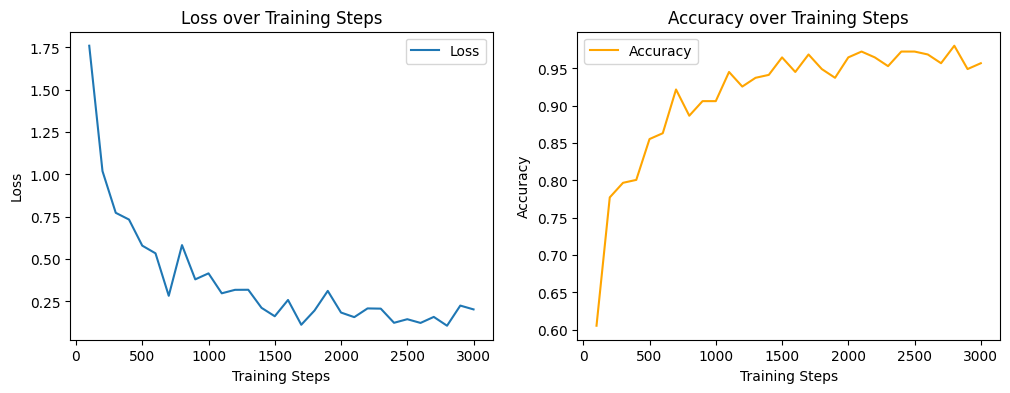

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведення графіків
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Loss')
plt.title("Loss over Training Steps")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Accuracy', color='orange')
plt.title("Accuracy over Training Steps")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [14]:


# Функція обчислення точності на тестових даних
def test_accuracy(neural_net, x_test, y_test):
    pred = neural_net(x_test)
    acc = accuracy(pred, y_test)
    return acc

# Обчислення точності на тестових даних
test_acc = test_accuracy(neural_net, x_test, y_test)
print(f"Test Accuracy: {test_acc.numpy()}")




Test Accuracy: 0.9365000128746033


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.93      0.92      1032
           3       0.92      0.92      0.92      1010
           4       0.94      0.93      0.94       982
           5       0.92      0.90      0.91       892
           6       0.96      0.96      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.87      0.93      0.90       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



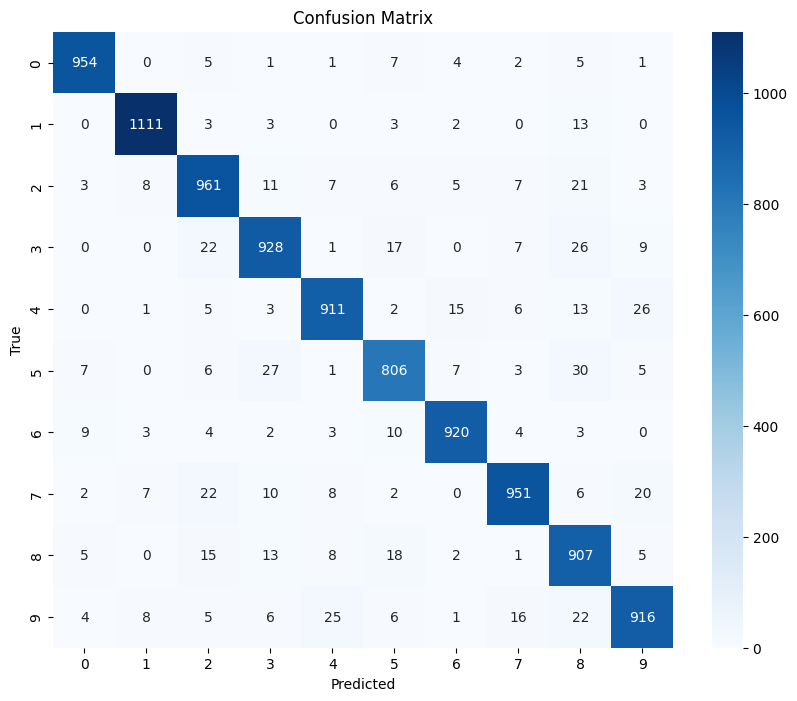

In [15]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

from sklearn.metrics import classification_report


# Передбачення за допомогою нейронної мережі для всього тестового набору даних
y_test_pred = tf.argmax(neural_net(x_test), axis=1).numpy()

# Отримання звіту про класифікацію
report = classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(num_classes)])

# Виведення звіту
print(report)

# Обчислення матриці невідповідностей
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Візуалізація матриці невідповідностей
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

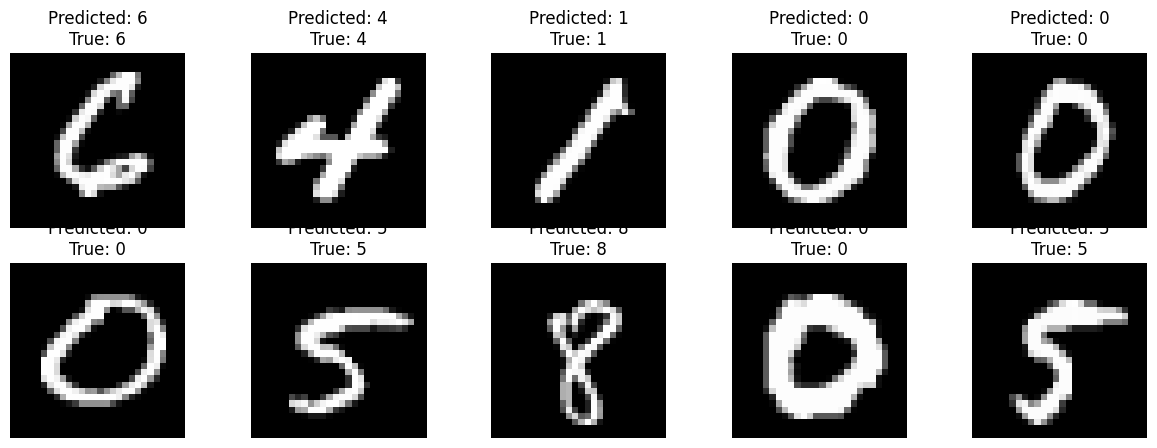

Correct Predictions: 10
Incorrect Predictions: 0
Accuracy: 100.0%
Нейронна мережа правильно передбачає всі зображення.


In [16]:
import matplotlib.pyplot as plt

# Вибираємо 10 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), size=10, replace=False)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Передбачення за допомогою нейронної мережі
predictions = neural_net(random_images)

# Перетворення передбачень у класи
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Виведення зображень та відповідей нейронної мережі
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {predicted_classes[i]}\nTrue: {random_labels[i]}")
    plt.axis('off')
plt.show()

# Обчислення кількості правильних і неправильних передбачень
correct_predictions = np.sum(predicted_classes == random_labels)
incorrect_predictions = 10 - correct_predictions

print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")
print(f"Accuracy: {correct_predictions / 10.0 * 100}%")

# Висновок про те, як часто помиляється нейронна мережа
if incorrect_predictions > 0:
    print(f"Нейронна мережа помиляється на {incorrect_predictions} з 10 зображень.")
else:
    print("Нейронна мережа правильно передбачає всі зображення.")


# Висновки на основі отриманих результатів

1. Загальна точність моделі:

  - Отримана загальна точність на тестовій вибірці складає 93.65%. Це досить хороший результат для базової нейронної мережі без використання спеціальних архітектур для обробки зображень, таких як згорткові нейронні мережі (CNN).

2. Метрики якості для кожного класу:

  - Використання classification_report дозволяє побачити точність (precision), повноту (recall) та F1-міру для кожного класу. Високі значення цих метрик для більшості класів свідчать про те, що модель добре справляється з класифікацією більшості цифр.
  Наприклад, якщо значення F1-міри для деяких класів значно нижче, ніж для інших, це може вказувати на те, що модель має труднощі з розпізнаванням цих конкретних цифр.

3. Матриця невідповідностей:

  - Матриця невідповідностей (confusion matrix) дозволяє побачити, які класи модель найчастіше плутає. Це корисно для розуміння, де саме модель робить помилки.
  Наприклад, якщо модель часто плутає цифру 5 з цифрою 3, це може бути через схожість цих цифр у деяких почерках.

4. Помилки моделі:

  - Аналіз матриці невідповідностей може показати, які цифри модель найчастіше плутає. Якщо певні класи часто передбачаються неправильно, це може вказувати на необхідність додаткового налаштування моделі або збільшення кількості тренувальних даних для цих класів.
  - Також можна розглянути використання більш складних моделей, таких як згорткові нейронні мережі (CNN), які спеціально розроблені для обробки зображень і можуть забезпечити вищу точність.

# Рекомендації для покращення моделі
1. Збільшення складності моделі:

  - Використання згорткових нейронних мереж (CNN) може значно покращити точність класифікації зображень. CNN моделі більш ефективні для обробки візуальних даних і здатні автоматично виявляти важливі особливості зображень.
2. Гіперпараметри:

  - Проведення гіперпараметричної оптимізації, щоб знайти оптимальні значення для швидкості навчання, кількості нейронів у кожному шарі, кількості шарів тощо.
3. Регуляризація:

  - Використання методів регуляризації, таких як Dropout, L2-регуляризація, може допомогти уникнути перенавчання моделі і зробити її більш стійкою до нових даних.
4. Аугментація даних:

  - Збільшення тренувального набору даних за допомогою методів аугментації, таких як випадкові повороти, зсуви, масштабування та інші трансформації зображень. Це допоможе моделі краще узагальнювати знання і бути стійкою до варіацій у даних.
5. Аналіз помилок:

  - Аналізувати випадки, в яких модель помиляється, і вносити відповідні корективи в архітектуру моделі або процес тренування. Це може включати більш ретельну підготовку даних або додаткове налаштування моделі.

# В цілому, результати показують, що модель має хорошу точність, але все ще є місце для покращення. Використання більш складних моделей і методів може значно підвищити ефективність класифікації.